In [1]:
import glob
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import cohen_kappa_score

In [2]:
submission_paths = "submissions/test/*.txt"
submissions = glob.glob(submission_paths)
len(submissions)

64

In [3]:
llmjudge_test = pd.read_csv("llmjudge-qrels/llmjudge_test_qrel_idx.txt", sep=" ", header=None, names=['qid', 'Q0', 'docid', 'score'])
llmjudge_test.head(5)

,qid,Q0,docid,score
0,q49,0,p3659,3
1,q49,0,p11027,3
2,q49,0,p1270,1
3,q49,0,p786,3
4,q49,0,p9577,2


In [5]:
import os
from collections import defaultdict
#from collections import Counter
import krippendorff

kappas = defaultdict(list)
for threshold in [-1, 1, 2, 3]:
    for submission_file in tqdm(submissions):
        filename = os.path.basename(submission_file)
        team , run = filename.split('.')[0].split('-')
        runid = f"{team}-{run}"
        submission_df = pd.read_csv(submission_file, sep=" ", header=None, names=['qid', 'Q0', 'docid', 'score'])
        submission_df['score'] = [0 if x < 0 else 3 if x > 3 else x for x in submission_df['score']]
        merged_df = pd.merge(llmjudge_test, submission_df, on=['qid', 'docid'], how='outer')
        if threshold > 0:
            merged_df['score_x'] = [1 if x >= threshold else 0 for x in merged_df['score_x']]
            merged_df['score_y'] = [1 if x >= threshold else 0 for x in merged_df['score_y']]
        # cohen_kappa = cohen_kappa_score(merged_df['score_x'], merged_df['score_y'])
        # print(runid, Counter(list(merged_df['score_x']) + list(merged_df['score_y'])))
        krippendorff_alpha = krippendorff.alpha(reliability_data=[merged_df['score_x'], merged_df['score_y']], value_domain=[0,1,2,3], level_of_measurement='ordinal')
        if runid == 'h2oloo-fewself' and threshold == 2:
            print(pd.crosstab(merged_df['score_x'], merged_df['score_y']))
        # kappas[runid].append(cohen_kappa)
        kappas[runid].append(krippendorff_alpha)

with open(f'llmjudge2024-submissions-cohens-kappa-binarized.txt', 'w') as fout:
    for runid in kappas.keys():
        kappa_tsv = '\t'.join([str(x) for x in kappas[runid]])
        fout.write(f"{runid}\t{kappa_tsv}\n")


 12%|█▎        | 8/64 [00:00<00:01, 37.98it/s]

score_y     0    1
score_x           
0        2719  519
1         483  702


100%|██████████| 64/64 [00:01<00:00, 44.07it/s]


In [6]:
import pandas as pd

df = pd.DataFrame(kappas, index=['krippendorff', 'kappa 0|123', 'kappa 01|23', 'kappa 012|3']).transpose()
df.to_clipboard()  # Plots in the talk were based on this data
df

,krippendorff,kappa 0|123,kappa 01|23,kappa 012|3
h2oloo-fewself,0.495764,0.410792,0.428016,0.297844
h2oloo-zeroshot1,0.481175,0.405772,0.385039,0.306258
h2oloo-zeroshot2,0.389818,0.341810,0.317459,0.276929
llmjudge-cot1,0.321845,0.176392,0.278760,0.115963
llmjudge-cot2,0.326346,0.217286,0.242937,0.200183
...,...,...,...,...
TREMA-rubric0,0.103604,0.117231,-0.089472,0.016718
TREMA-sumdecompose,0.392616,0.313767,0.343022,0.199542
willia-umbrela1,0.491793,0.412928,0.393941,0.312438
willia-umbrela2,0.455608,0.396124,0.329797,0.319274


c:\Users\nickcr\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


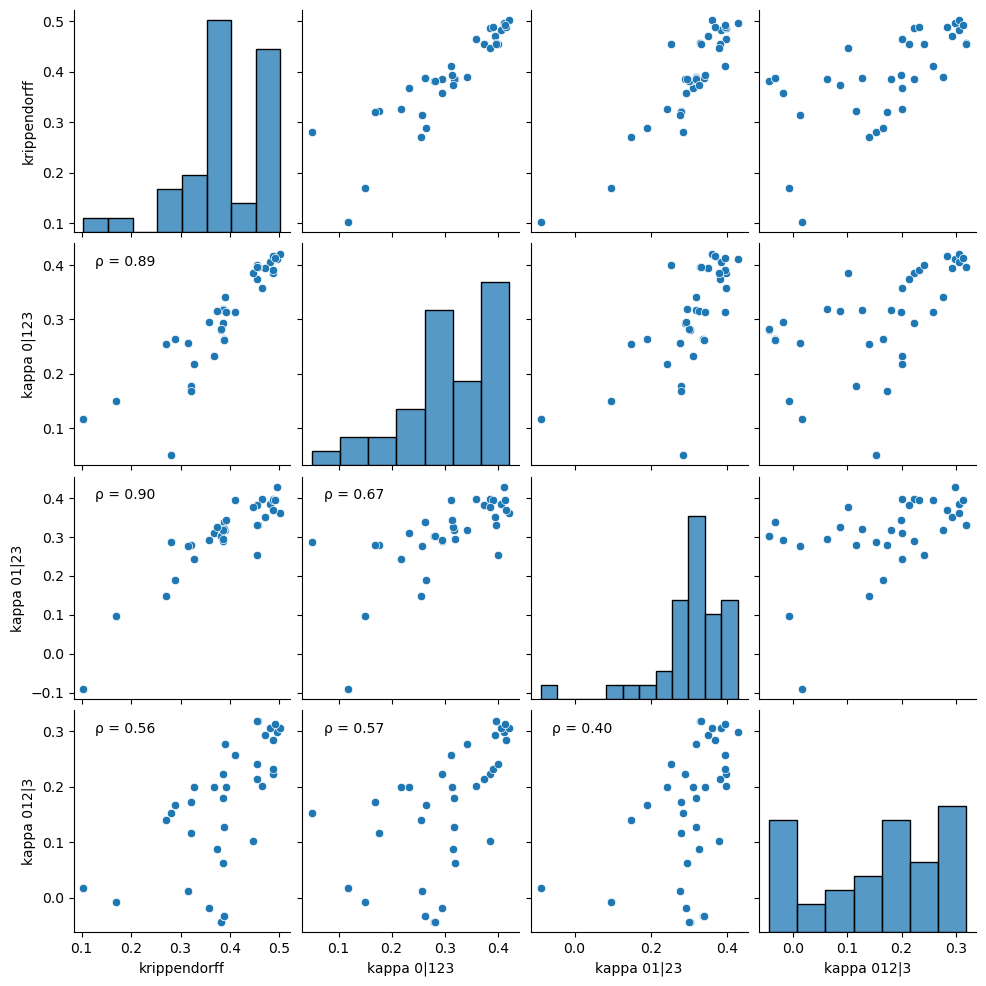

In [7]:
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

# Warning: We should include the "prophet" runs that did not overfit (the
# participant said he would share which ones), and remove any overfitting cases
# too e.g. Ronak mentioned
df_reduced = df[[not 'prophet' in x for x in df.index]]

#sns.scatterplot(data=df, x='ge2', y='4point')
#g = sns.pairplot(data=df)
g = sns.pairplot(data=df_reduced)
g.map_lower(corrfunc)
plt.show()



In [8]:
print(len(df), 'submissions:')
print(df.mean())

print(len(df_reduced), 'submissions:')
print(df_reduced.mean())



64 submissions:
krippendorff    0.404692
kappa 0|123     0.350126
kappa 01|23     0.316514
kappa 012|3     0.197173
dtype: float64
39 submissions:
krippendorff    0.388995
kappa 0|123     0.304839
kappa 01|23     0.307218
kappa 012|3     0.153313
dtype: float64
